# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re

pd.options.display.float_format = '{:.1f}'.format
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

#### Посмотрим общую информацию.

In [2]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,nan,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,nan
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,nan,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,nan,0.0,nan,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,nan,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,nan,14.0,nan,9,NaN,...,nan,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.0,14.0,32.0,13,NaN,...,41.0,nan,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,nan,12.0,14.4,5,NaN,...,9.1,nan,городской посёлок Янино-1,nan,nan,nan,nan,nan,nan,55.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,nan,26.0,10.6,6,NaN,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,nan,0.0,nan,155.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,nan,24.0,nan,22,NaN,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,nan,0.0,nan,nan
8,20,2900000.0,33.2,2018-05-23T00:00:00,1,nan,27.0,15.4,26,NaN,...,8.8,nan,посёлок Мурино,nan,nan,nan,nan,nan,nan,189.0
9,18,5400000.0,61.0,2017-02-26T00:00:00,3,2.5,9.0,43.6,7,NaN,...,6.5,2.0,Санкт-Петербург,50898.0,15008.0,0.0,nan,0.0,nan,289.0


Количество значений в столбцах различается. Это говорит о том, что в данных есть пропуски.

    airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
    balcony — число балконов
    ceiling_height — высота потолков (м)
    cityCenters_nearest — расстояние до центра города (м)
    days_exposition — сколько дней было размещено объявление (от публикации до снятия)
    first_day_exposition — дата публикации
    floor — этаж
    floors_total — всего этажей в доме
    is_apartment — апартаменты (булев тип)
    kitchen_area — площадь кухни в квадратных метрах (м²)
    last_price — цена на момент снятия с публикации
    living_area — жилая площадь в квадратных метрах(м²)
    locality_name — название населённого пункта
    open_plan — свободная планировка (булев тип)
    parks_around3000 — число парков в радиусе 3 км
    parks_nearest — расстояние до ближайшего парка (м)
    ponds_around3000 — число водоёмов в радиусе 3 км
    ponds_nearest — расстояние до ближайшего водоёма (м)
    rooms — число комнат
    studio — квартира-студия (булев тип)
    total_area — площадь квартиры в квадратных метрах (м²)
    total_images — число фотографий квартиры в объявлении

Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.

In [3]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.0,23699.0,23699.0,23699.0,14504.0,23613.0,21796.0,23699.0,21421.0,12180.0,18157.0,18180.0,18181.0,8079.0,18181.0,9110.0,20518.0
mean,9.9,6541548.8,60.3,2.1,2.8,10.7,34.5,5.9,10.6,1.2,28793.7,14191.3,0.6,490.8,0.8,518.0,180.9
std,5.7,10887013.3,35.7,1.1,1.3,6.6,22.0,4.9,5.9,1.1,12630.9,8608.4,0.8,342.3,0.9,277.7,219.7
min,0.0,12190.0,12.0,0.0,1.0,1.0,2.0,1.0,1.3,0.0,0.0,181.0,0.0,1.0,0.0,13.0,1.0
25%,6.0,3400000.0,40.0,1.0,2.5,5.0,18.6,2.0,7.0,0.0,18585.0,9238.0,0.0,288.0,0.0,294.0,45.0
50%,9.0,4650000.0,52.0,2.0,2.6,9.0,30.0,4.0,9.1,1.0,26726.0,13098.5,0.0,455.0,1.0,502.0,95.0
75%,14.0,6800000.0,69.9,3.0,2.8,16.0,42.3,8.0,12.0,2.0,37273.0,16293.0,1.0,612.0,1.0,729.0,232.0
max,50.0,763000000.0,900.0,19.0,100.0,60.0,409.7,33.0,112.0,5.0,84869.0,65968.0,3.0,3190.0,3.0,1344.0,1580.0


#### Найдем пропуски в таблице и просуммируем по каждому стобцу.

In [4]:
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Вывод

Изучив общую информацию, были обнаружены пропуски, некорректные названия столбцов, неподходящий формат времени и даты.

### Шаг 2. Предобработка данных

#### Переименуем столбцы для удобства дальнейшей работы.

In [5]:
df.set_axis(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'], axis='columns', inplace=True)

#### Преобразуем дату и время в общепринятый формат методом to_datetime() и проверим первые 5 строк.

In [6]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

In [7]:
df['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

#### Преобразуем данные в столбце аппартаментов.

In [8]:
df['is_apartment'].unique()

array([nan, False, True], dtype=object)

Значения в столбце имеют булевый тип данных(False, True) и пропуски(nan). 
Пропуски могут быть связаны с тем, что люди пропускают данный параметр, т.к либо они вообще никогда не сталкивались с данным типом помещений, либо аппартаменты отсутствуют и люди их не указывают, т.к для них это не имеет значения. 
Из пункта 1.2 мы видим что, пропусков в данном столбце 20924(почти все объявления). Если исходить из того, что в основном люди сдают жилые помещения, чем не являются аппартаменты де-юре, то можно сделать вывод, что пропуски - это отсутствие аппартаментов, то есть False.
Преобразуме пропуски в булевый тип данных False.

In [9]:
df['is_apartment'] = df['is_apartment'].fillna('False').astype(bool)

#### Преобразуем данные в столбцах чисел парков, водоемов и балконов

Из пункта 1.2 видно, что в обоих столбцах 5518 по пропусков. Данные пропуски могу быть обусловлены технической ошибкой при выгрузке, либо люди намерено пропускали данные параметры. Например, человек может не знать где этот радиус в 3000 метров. В данном случае приходится отталкиваться от того, что человек не знает либо не уверен, что в радиусе 3000 метров есть парк или водоем, поэтому заменим пропуск на 0(отсутствие) и преобразуем в числовой тип данных.

In [10]:
df['parks_around_3000']= df['parks_around_3000'].fillna(0).astype(int)

In [11]:
df['ponds_around_3000'] = df['ponds_around_3000'].fillna(0).astype(int)

Таким же образом поступим и с балконами.

In [12]:
df['balcony'] = df['balcony'].fillna(0).astype(int)

#### Удаляем пропуски из столбца названия населенного пунка и количество этажей в доме.

Из пункта 1.2 видно, что в столбце названия населенного пункта всего 49 пропусков, а пропусков количества этажей всего 86. Пропусков настолько мало, что их удаление никак не повлияет на результат исследования.

In [13]:
df.dropna(subset = ['locality_name'], inplace = True)

In [14]:
df.dropna(subset = ['floors_total'], inplace = True)

#### Проверяем наличие дубликатов в столбце названия населенного пунка

Проверим наличие грубых дубликатов(повторов) методом duplicated().

In [15]:
df.duplicated().sum()

0

Дубликаты могут быть образованы разной формой записи, например могут имет разный регистр.

In [16]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Есть дубликаты связанные с разнообразием написания буквы е/ё. Так же уберем тип населенного пункта, оставим только наименования, чтобы исключить дубликаты населенных бунктов, указанных без типа населенного пункта.

#### Преобразуем данные в столбеце 'locality_name' к единому виду.

In [17]:
def modify_locality_name(row):
    if pd.isna(row['locality_name']):
        return row['locality_name']
    change = row['locality_name'].replace('ё', 'е')
    return re.sub(r'\b[а-я]+\s*', "", change).strip()

df['modify_locality_name'] = df.apply(modify_locality_name, axis=1)
df['modify_locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодежное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

#### Разберемся с пропусками высоты потолков.

Заполним пропуски высоты потолков медианной величиной, сгруппировав по названию населенного пункта.

In [18]:
df['ceiling_height'].fillna(df.groupby('modify_locality_name')['ceiling_height'].transform('median'), inplace=True)
df['ceiling_height'].isnull().sum()

95

Удалим оставшиеся пропуски.

In [19]:
df.dropna(subset = ['ceiling_height'], inplace = True)

#### Заполним пропуски растояния до центра

In [20]:
df['city_centers_nearest'].fillna(df.groupby('modify_locality_name')['city_centers_nearest'].transform('median'), inplace=True)
df['city_centers_nearest'].isnull().sum()

5342

### Шаг 3. Посчитайте и добавьте в таблицу

#### Посчитаем стоимость квадратного метра и добавим в таблицу.

In [21]:
df['price_per_square_metre'] = df['last_price'] / df['total_area']

#### Добавим день недели, месяц, год публикации обьявления.

In [22]:
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month

In [23]:
df['weekday'] = df['first_day_exposition'].dt.weekday

In [24]:
df['year'] = df['first_day_exposition'].dt.year

#### Обозначим этаж(первый или последний)

In [25]:
def defining_floor(df):
    if df['floor'] == 1:
        return 'первый'
    elif (df['floors_total'] == df['floor']) & (df['floor'] != 1):
        return 'последний'
    else:
        return 'другой'
    

df['defining_floor'] = df.apply(defining_floor, axis=1)

#### Посчитаем соотношения площадей в квартире

Соотношение жилой площади к общей.

In [26]:
df['living_to_total'] = df['living_area'] / df['total_area']

Соотношение площади кухни к общей площади.

In [27]:
df['kitchen_to_total'] = df['kitchen_area'] / df['total_area']

Заполним пропуски в столбцах соотношения площадей .

In [28]:
df['living_to_total'].fillna(df.groupby(['modify_locality_name'])['living_to_total'].transform('median'), inplace=True)

In [29]:
df['kitchen_to_total'].fillna(df.groupby(['modify_locality_name'])['kitchen_to_total'].transform('median'), inplace=True)

Удалим пропуски

In [30]:
df['living_to_total'].isnull().sum()

5

In [31]:
df.dropna(subset = ['living_to_total'], inplace = True)

In [32]:
df['kitchen_to_total'].isnull().sum()

1

In [33]:
df.dropna(subset = ['kitchen_to_total'], inplace = True)

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### Площадь квартир

In [34]:
df['total_area'].describe()

count   23464.0
mean       60.4
std        35.7
min        12.0
25%        40.0
50%        52.0
75%        69.9
max       900.0
Name: total_area, dtype: float64

In [35]:
def show_hist(column, bins, xlabel, ylabel, title):
    ax = (
        column.plot(
            kind='hist', 
            histtype='step', 
            bins=bins, 
            linewidth=5, 
            alpha=0.7,  
            figsize=(15, 7), 
            grid=True)
    )
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);
    ax.set_title(title);

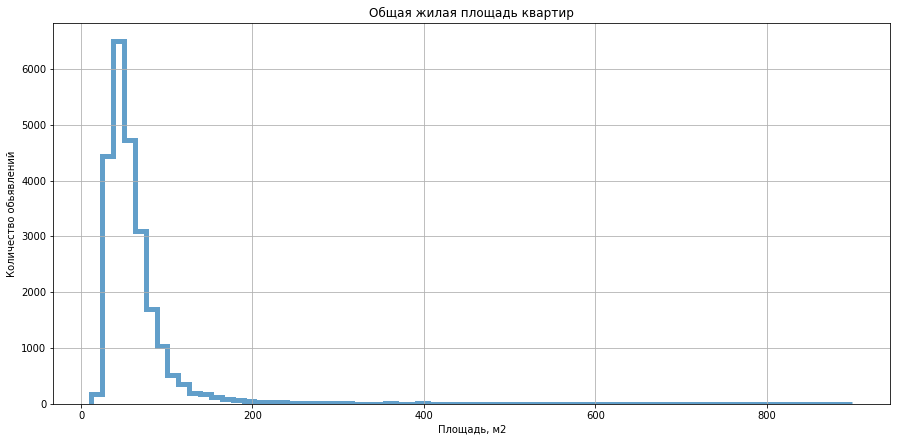

In [36]:
show_hist(df['total_area'], 70, 'Площадь, м2', 'Количество обьявлений', 'Общая жилая площадь квартир')

В целом такое распределение похоже на правду. Есть отклонения, связанные с большой площадью. Это могут быть, например двухэтажные квартиры, Основная группа распределена между 30 м2 и 75 м2.

(0, 160)

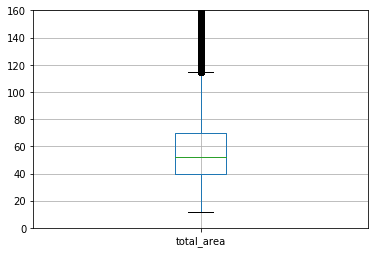

In [37]:
df.boxplot('total_area')
plt.ylim(0, 160)

Согласно диаграмме размаха, выбросами явдяются данные, площадь которых превышает 120 м2, но если исходить из реалей(например циан), то есть квартиры и по 200 и 300 м2. Поэтому от таких выбросов мы не избавляемся в данном случае. 

#### Стоимость квартир

In [38]:
df['last_price'].describe()

count       23464.0
mean      6560696.5
std      10929520.1
min         12190.0
25%       3450000.0
50%       4650000.0
75%       6800000.0
max     763000000.0
Name: last_price, dtype: float64

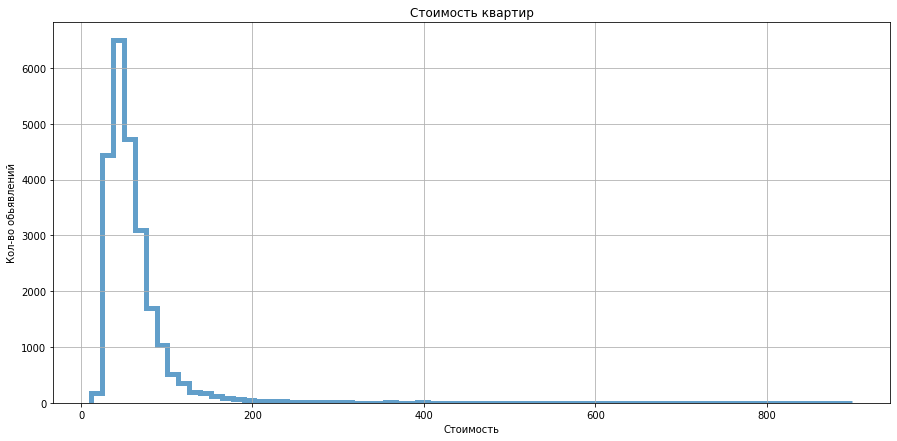

In [39]:
show_hist(df['total_area'], 70, 'Стоимость', 'Кол-во обьявлений', 'Стоимость квартир')

(0, 20000000)

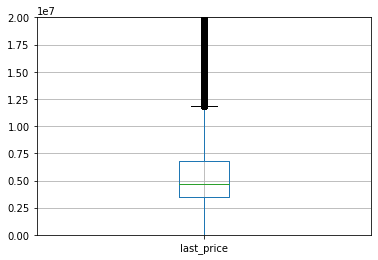

In [40]:
df.boxplot('last_price')
plt.ylim(0, 20000000)

Основная группа находится в пределах до 10 млн руб. Выбросами являютс очень дорогие квартиры, но по сравнению с основной группой их не так много, судя по данным гистограммы. В основном стоимость квартиры зависит от ее площади и месторасположения, а так как мы выяснили, что есть квартиры больше 200 м2, то просто так нам нельзя удалить выбросы с огромными ценниками. 

#### Количество комнат в квартире

In [41]:
df['rooms'].describe()

count   23464.0
mean        2.1
std         1.1
min         0.0
25%         1.0
50%         2.0
75%         3.0
max        19.0
Name: rooms, dtype: float64

Минимальное значение 0. Таким образом люди могли указать квартиру-студию. В подобных случаях изменим количество комнат с 0 на 1 для корректного отображения. 

In [42]:
df.loc[df['rooms'] == 0, 'rooms'] = 1

Text(0, 0.5, 'Кол-во обьявлений, шт.')

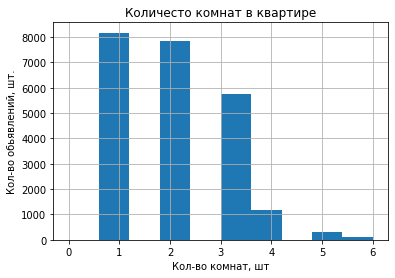

In [43]:
df.hist(bins=10, range=(0, 6), column='rooms')
plt.title('Количесто комнат в квартире')
plt.xlabel('Кол-во комнат, шт')
plt.ylabel('Кол-во обьявлений, шт.')

Из графика видно, что в основном сдают 1, 2 и 3-комнтаные квартиры.

#### Высота потолков квартир

In [44]:
df['ceiling_height'].describe()

count   23464.0
mean        2.7
std         1.0
min         1.0
25%         2.5
50%         2.7
75%         2.7
max       100.0
Name: ceiling_height, dtype: float64

Минимальная высота составляет 1 м. Минимальная высота потолков в России составляет 2,4. Для осчета возьмем высоту в 2 м, а потолки ниже этой высоты будем считать ошибочными, такие данные не будем брать в расчет. За максимальную высоту возьмем 8 метров, например двухуровневая дореволюционная квартира, что маловероятно, но все-таки возьмем за максимум и отбросим все лишнее. 

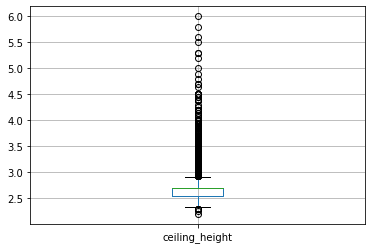

In [45]:
clear_df = df.query('2 < ceiling_height < 8')
clear_df.boxplot('ceiling_height')


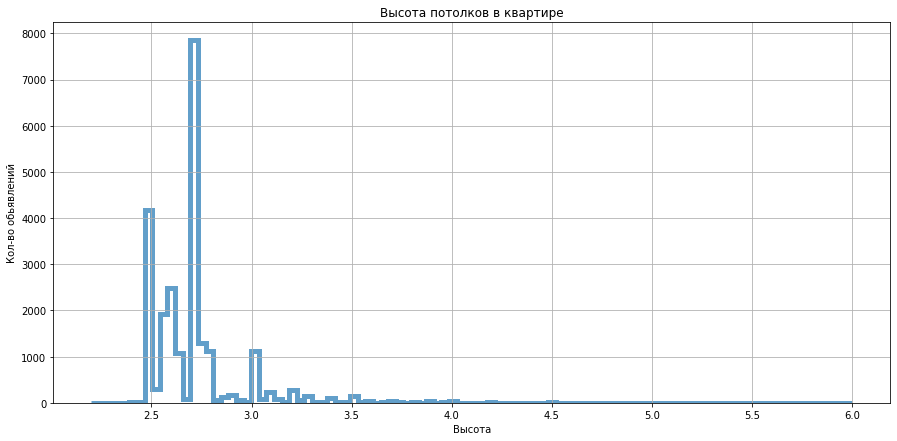

In [46]:
show_hist(clear_df['ceiling_height'], 100, 'Высота', 'Кол-во обьявлений', 'Высота потолков в квартире')

В основном потолки в Санкт-Петербурге высотой 2,7.

#### Изучим время продажи квартиры

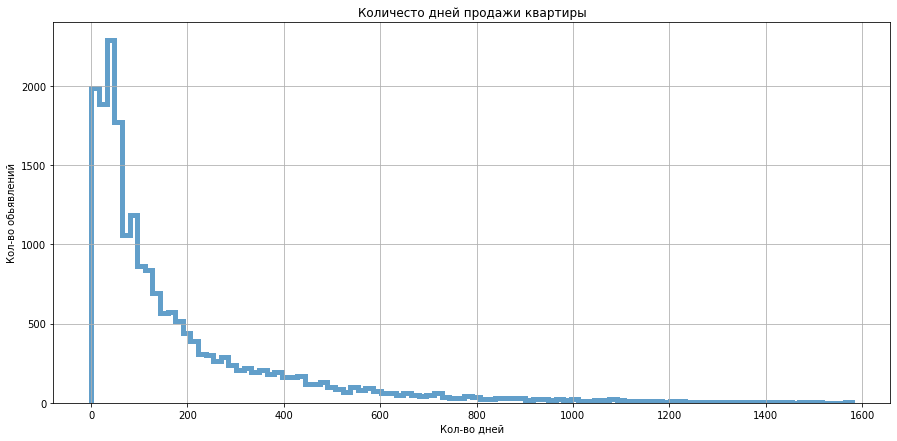

In [47]:
show_hist(df['days_exposition'], 100, 'Кол-во дней', 'Кол-во обьявлений', 'Количесто дней продажи квартиры')

In [48]:
df['days_exposition'].describe()

count   20316.0
mean      181.0
std       219.9
min         1.0
25%        45.0
50%        95.0
75%       232.0
max      1580.0
Name: days_exposition, dtype: float64

Если квартира продается за 45 дней, то можно считать, что это быстрая продажа. До 200 дней можно считать, что продажа квартиры продалжалась очень долго. Среднее арифметическое время продажи квартиры составляет 181, медианное время продажи составляет 95 дней. 

#### Анализ факторов, влияющих на стоимость квартиры. 

##### Зависимость цены и площади квартиры

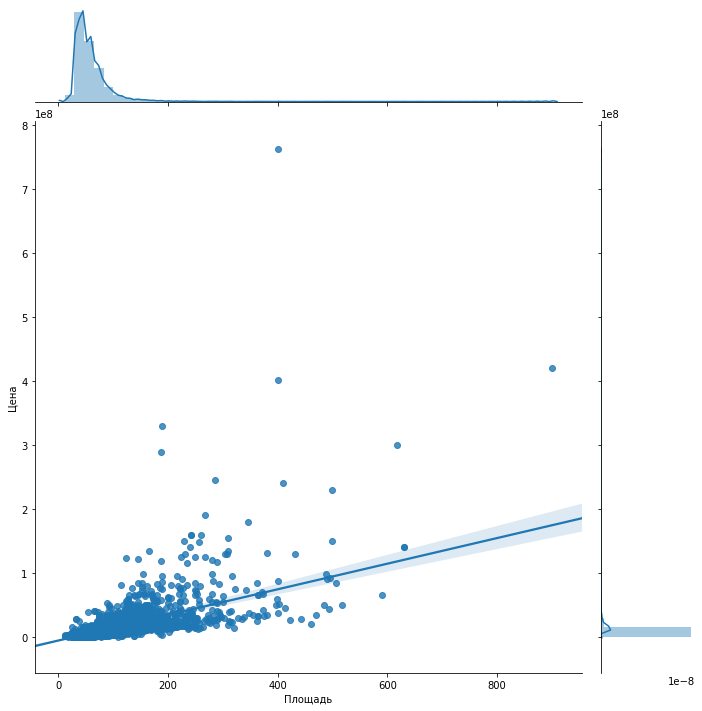

In [49]:
ax = sns.jointplot(x='total_area', y='last_price', 
                  data=df[df['total_area'].notnull()],
                  kind='reg',
                  height=10,
                  dropna=True
                 )
ax.set_axis_labels('Площадь', 'Цена')

In [50]:
df[df['total_area'].notnull()]['total_area'].corr(df[df['total_area'].notnull()]['last_price'])

0.6537926706460447

Если исходить и гистограммы и коэффициента корреляции Пирсона, то существует зависимость между площадью и стоимостью квартиры, но не слишком сильная. 

##### Зависимость цены и количества комнат квартиры

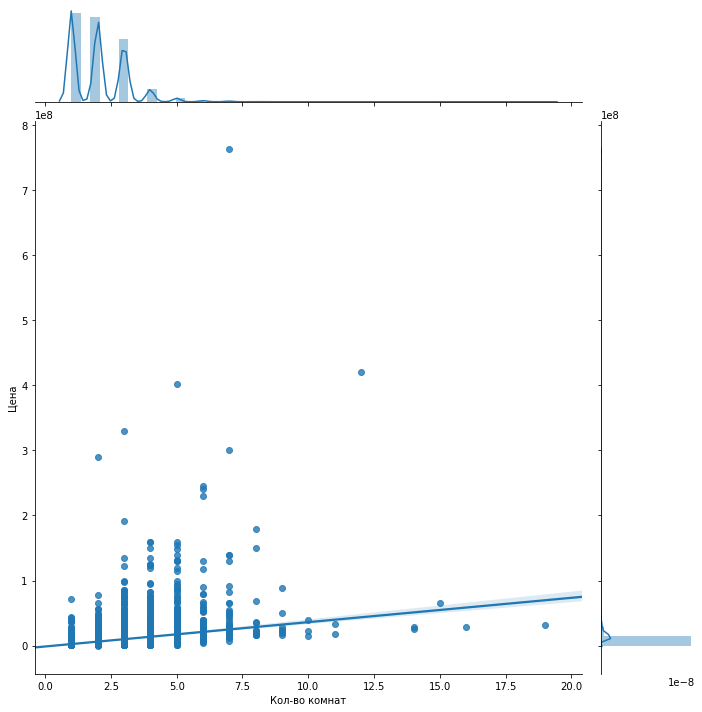

In [51]:
ax = sns.jointplot(x='rooms', y='last_price', 
                  data=df[df['rooms'].notnull()],
                  kind='reg',
                  height=10,
                  dropna=True
                 )
ax.set_axis_labels('Кол-во комнат', 'Цена')

In [52]:
df[df['rooms'].notnull()]['rooms'].corr(df[df['rooms'].notnull()]['last_price'])

0.3651817346247512

В данном случае не стоит говорить о зависимости цены от количества комнат квартиры. Например, 1-комнатная квартира может стоить центре города дороже, чем на окраине. 

##### Зависимость цены квартиры и удаленности от центра города.

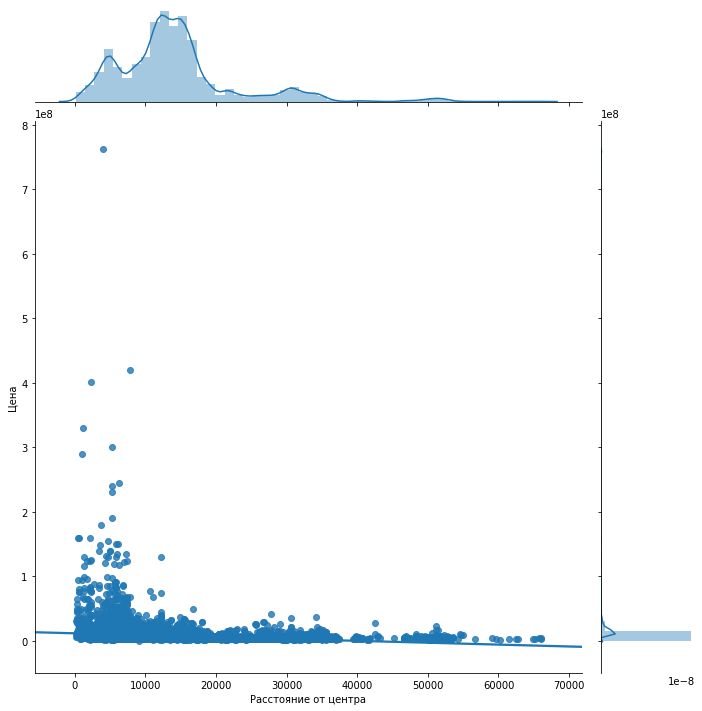

In [53]:
ax = sns.jointplot(x='city_centers_nearest', y='last_price', 
                  data=df[df['city_centers_nearest'].notnull()],
                  kind='reg',
                  height=10,
                  dropna=True
                 )
ax.set_axis_labels('Расстояние от центра', 'Цена')

In [54]:
df[df['city_centers_nearest'].notnull()]['city_centers_nearest'].corr(df[df['city_centers_nearest'].notnull()]['last_price'])

-0.20568516418617785

По графи видно, что чем ближе к центру, тем квартира дороже, что совпадает с дейсвительностю любого города. 

##### Зависимость цены от этажа квартиры. 

Text(0, 0.5, 'Стоимость')

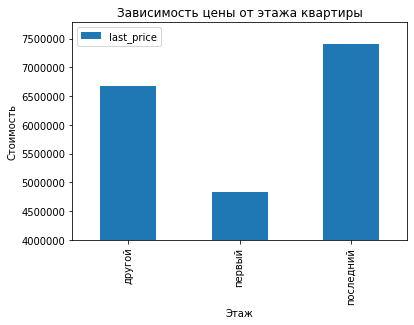

In [55]:
df.pivot_table(index='defining_floor', values='last_price').plot(ylim=(4000000), kind='bar')
plt.title('Зависимость цены от этажа квартиры')
plt.xlabel('Этаж')
plt.ylabel('Стоимость')

Из графика видно, что люди готовы переплачивать за последние этажи(самые высокие цены). В городской среде на последних этажах и воздух почище, и солнечного света побольше, и шума поменьше(нет соседей сверху и шума от транспорта). 

##### Зависимость от даты и дня недели размещения. 

Text(0, 0.5, 'Стоимость')

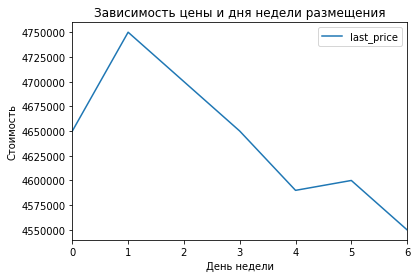

In [56]:
df.pivot_table(index='weekday', values='last_price', aggfunc='median').plot()
plt.title('Зависимость цены и дня недели размещения')
plt.xlabel('День недели')
plt.ylabel('Стоимость')

Судя по графику, в первой половине недели размещаются самые дорогие квартиры. 

Text(0, 0.5, 'Стоимость')

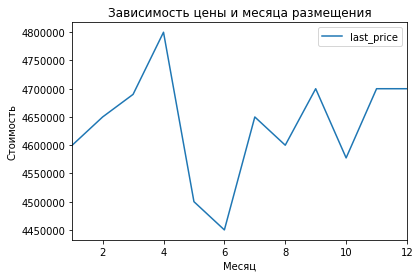

In [57]:
df.pivot_table(index='month', values='last_price', aggfunc='median').plot()
plt.title('Зависимость цены и месяца размещения')
plt.xlabel('Месяц')
plt.ylabel('Стоимость')

Из графика можно сказать, что самые низкие цены на квартиру с мая по июнь. 

Text(0, 0.5, 'Стоимость')

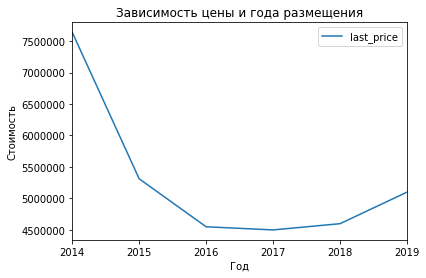

In [58]:
df.pivot_table(index='year', values='last_price', aggfunc='median').plot()
plt.title('Зависимость цены и года размещения')
plt.xlabel('Год')
plt.ylabel('Стоимость')

Очередной кризис российской экономики в 2014 году, случившися в результате санкций и падения цен на нефть, еще больше обесценил рубль, а реальный доход граждан снизился, снизилась и покупательная способность. Возможно поэтому и упали цены на квартиры. 

#### Анализ 10 населенных пунктов с наибольшим количеством обьявлений

In [59]:
top_10_locality = (df.pivot_table(index='modify_locality_name', 
                                  values=['last_price'],
                                  aggfunc=['count', 'mean'])
                   .sort_values(by=('count', 'last_price'), ascending=False)).head(10)
top_10_locality

,count,mean
,last_price,last_price
modify_locality_name,,
Санкт-Петербург,15651,8064895.3
Мурино,586,3680840.8
Кудрово,470,4354895.2
Шушары,439,4109808.7
Всеволожск,398,3789067.8
Пушкин,369,6469035.9
Колпино,338,3964021.4
Парголово,327,4488074.8


Text(0, 0.5, 'Цена')

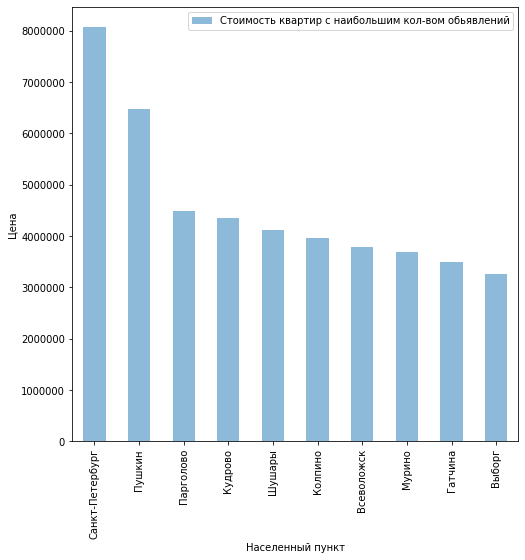

In [60]:
ax = (top_10_locality.sort_values(by=('mean', 'last_price'), ascending=False)
      .plot(kind='bar', 
            y=('mean', 'last_price'), 
            legend=True, 
            label='Стоимость квартир с наибольшим кол-вом обьявлений', alpha=0.5, figsize=(8, 8)))
ax.set_xlabel('Населенный пункт')
ax.set_ylabel('Цена')

Самые дорогие квартиры в Санкт-Петергбурге, что и следовало ожидать. 

#### Зависимость цены и удаленности от центра

In [61]:
spb_data = clear_df.query('(modify_locality_name=="Санкт-Петербург") and (city_centers_nearest.notnull())')
spb_data['city_centers_nearest_km'] = (round(spb_data['city_centers_nearest']/1000)).astype('int')
spb_data.pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='mean').head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,last_price
city_centers_nearest_km,
0,31449115.9
1,21206720.8
2,17788319.6
3,11146436.2
4,13309090.7


Text(0, 0.5, 'Цена')

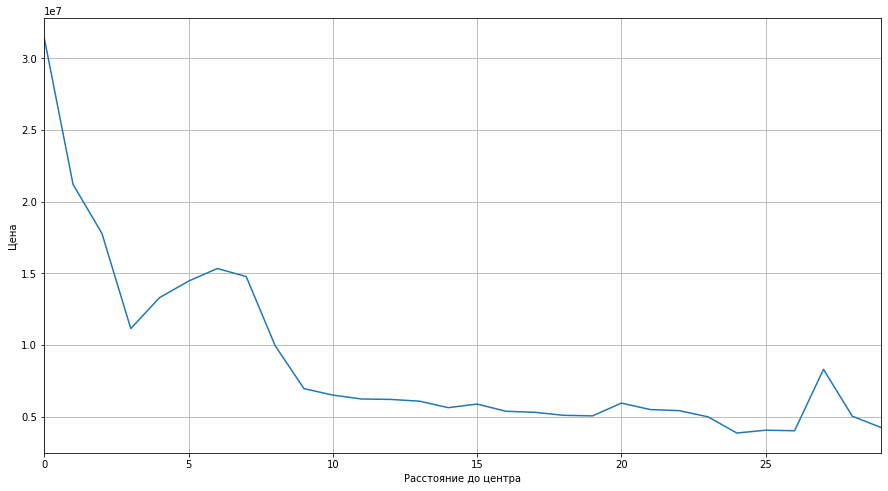

In [62]:
ax = (spb_data.pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='mean')).reset_index().plot(x='city_centers_nearest_km', y='last_price', grid=True, figsize=(15, 8), legend=False, label='Зависимость цены квартиры от растояния до центра')
ax.set_xlabel('Расстояние до центра')
ax.set_ylabel('Цена')

Из графика видно, что цены резко падают примерно после 8 км. Из этого следует, что центром города можно считать радиус в 7 км. 

#### Анализ цен в центре города

Выделим сегмент квартир в центре города. 

In [63]:
spb_center = spb_data.query('city_centers_nearest_km < 9')

##### Проанализируем площадь квартир в центре города. 

In [64]:
spb_center['total_area'].describe()

count   4106.0
mean      90.3
std       58.9
min       12.0
25%       55.0
50%       76.0
75%      107.0
max      900.0
Name: total_area, dtype: float64

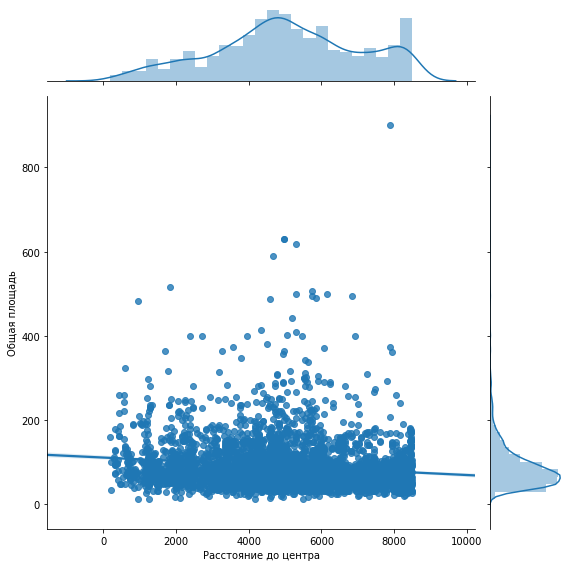

In [65]:
ax = sns.jointplot(x='city_centers_nearest', 
                   y='total_area', 
                   data=spb_center, 
                   kind='reg', height=8, dropna=True)
ax.set_axis_labels('Расстояние до центра', 'Общая площадь')

В центре города в основном квартиры площадью до 150 м2. В среднем по медиане площадб квартиры составляет 78,6 м2. 

##### Проанализируем стоимость квартир в центре города. 

In [66]:
spb_center['last_price'].describe()

count        4106.0
mean     14182457.2
std      23620501.0
min       1600000.0
25%       6450000.0
50%       8950000.0
75%      13900000.0
max     763000000.0
Name: last_price, dtype: float64

Text(0, 0.5, 'Стоимость')

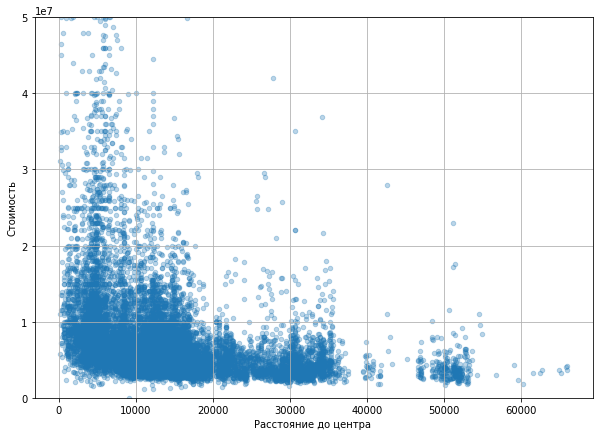

In [67]:
df.plot(x='city_centers_nearest', y='last_price',
                kind='scatter', grid=True, alpha=0.3,
                ylim=(0, 50000000), 
                figsize=(10, 7))
plt.xlabel('Расстояние до центра ')
plt.ylabel('Стоимость')

Из графика видно, что самы дорогие квартиры находяться в пределах до 10 км от центра и дальше снижается. 

##### Проанализируем кол-во комнат в квартире в центре города. 

In [68]:
spb_center['rooms'].describe()

count   4106.0
mean       2.8
std        1.4
min        1.0
25%        2.0
50%        3.0
75%        3.0
max       19.0
Name: rooms, dtype: float64

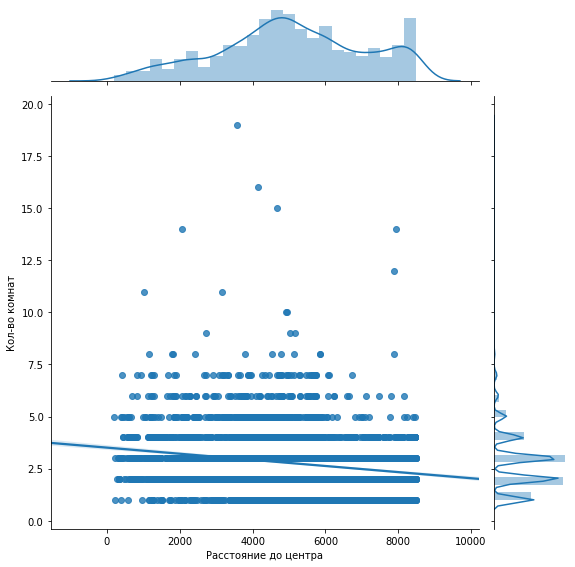

In [69]:
ax = sns.jointplot(x='city_centers_nearest', 
                   y='rooms', 
                   data=spb_center, 
                   kind='reg', height=8, dropna=True)
ax.set_axis_labels('Расстояние до центра', 'Кол-во комнат')

В центре города количнство комнат резко отличается. На данные показатель может влиять наличие элитного жилья, апартаменты. По мере отдаленности кол-во комнат снижается. 

##### Проанализируем высоту потолков в квартире в центре города. 

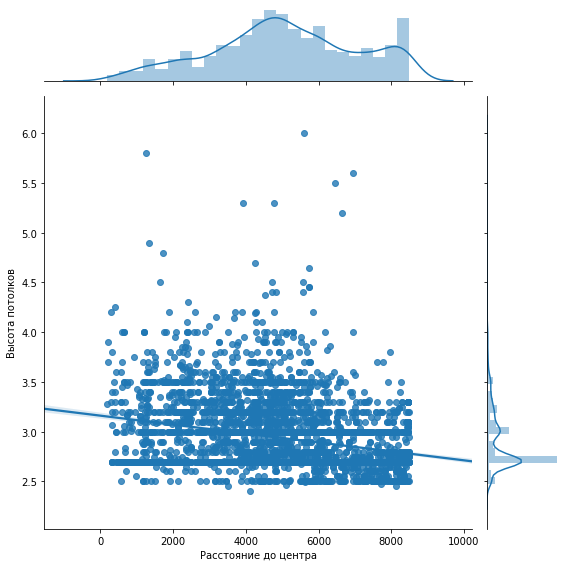

In [70]:
ax = sns.jointplot(x='city_centers_nearest', 
                   y='ceiling_height', 
                   data=spb_center, 
                   kind='reg', height=8, dropna=True)
ax.set_axis_labels('Расстояние до центра', 'Высота потолков')

In [71]:
spb_center['ceiling_height'].describe()

count   4106.0
mean       2.9
std        0.3
min        2.4
25%        2.7
50%        2.8
75%        3.1
max        6.0
Name: ceiling_height, dtype: float64

В центре города высота потолков отличаетс. В основном высота потолков от 2,4 до 4, что можно обьяснить наличием многоуровневых квартир, элитного жилья. 

##### Проанализируем дату размещения обьявления в центре города. 

Text(0, 0.5, 'Стоимость')

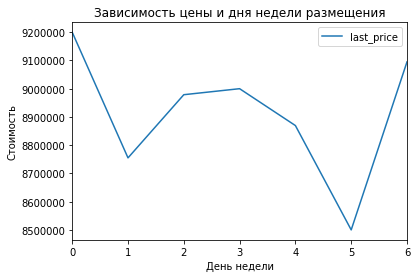

In [72]:
spb_center.pivot_table(index='weekday', values='last_price', aggfunc='median').plot()
plt.title('Зависимость цены и дня недели размещения')
plt.xlabel('День недели')
plt.ylabel('Стоимость')

Text(0, 0.5, 'Стоимость')

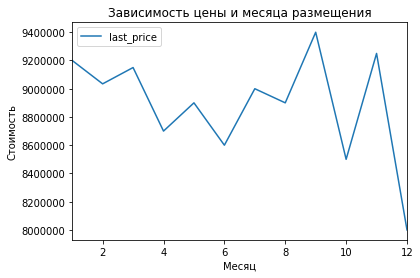

In [73]:
spb_center.pivot_table(index='month', values='last_price', aggfunc='median').plot()
plt.title('Зависимость цены и месяца размещения')
plt.xlabel('Месяц')
plt.ylabel('Стоимость')

Text(0, 0.5, 'Стоимость')

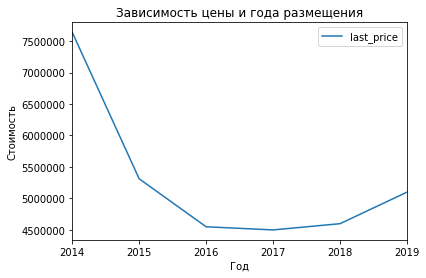

In [74]:
df.pivot_table(index='year', values='last_price', aggfunc='median').plot()
plt.title('Зависимость цены и года размещения')
plt.xlabel('Год')
plt.ylabel('Стоимость')

В целом тенденция даты размещения обьявления в центре схожа со всеми остальными обьявлениями в Санкт-Петербурге.

### Шаг 5. Общий вывод

Проанализировав все показатели, мы пришли к выводу, что на стоимость квартир влияет отдаленность от центра, чем дальше, тем дешевле. Так же влияет и этаж квартиры, видно, что люди готовы переплачивать за последние этажи(самые высокие цены). В городской среде на последних этажах и воздух почище, и солнечного света побольше, и шума поменьше(нет соседей сверху и шума от транспорта). На первом этаже квартиры заметно дешевле. 
С увеличением кол-ва комнат увеличивается и стоимость квартиры, в среднем продаются 2-комнатные квартиры за 5 млн руб, в центре 3-комнатные в пределах от 6,5 до 14 млн руб. 
Время размещения влияет на стоимость. В кризисные года стоимость падает. Так же заметно как весной цена на квартиры снижается, а с июня начинает расти. Продажа квартиры занимает около 3 месяцев. Если квартира продается за 45 дней, то это считается быстрой продажей. Больше всего квартир продается в Санкт-Петербурге, т.к там самый большой жилой фонд. Так же в топ 5 входят Мурино, Кудрово, Шушары, Всеволжск соответственно. 